In [197]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
import seaborn as sns
import pingouin as pg
from tqdm import tqdm

from src import data, paths, matrix_filtering, communicatin_metrics, plotting
from scipy import signal

from sklearn import metrics as sk_metrics
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

plt.style.use('ggplot')
%matplotlib inline

!date -I

2024-05-17


## Settings

In [198]:
SELECTED_SC_MATRIX = "Mica-Mics_dist"
EMPIRICAL_SIMULATED =   'empirical' # 'simulated' #
RESPONSE_LENGTH = 200
GRAPH_DENSITY = 0.25

WHEN_NOT_OVER_THRESHOLD = np.nan

In [199]:
fig_dir = f"pytepfit_results/{EMPIRICAL_SIMULATED}/{RESPONSE_LENGTH}/not_over_threshold_{str(WHEN_NOT_OVER_THRESHOLD)}/"
if SELECTED_SC_MATRIX != "Mica-Mics_rh":
    fig_dir+=f"{SELECTED_SC_MATRIX}/"

%mkdir -p  {paths.path_figures(fig_dir)}


results_dir = f'interim/pyTepFit_{EMPIRICAL_SIMULATED}/not_over_threshold_{str(WHEN_NOT_OVER_THRESHOLD)}/'
if SELECTED_SC_MATRIX != "Mica-Mics_rh":
    results_dir+=f"{SELECTED_SC_MATRIX}/"

%mkdir -p {paths.path(results_dir)}

In [200]:
color7_dict= {'Default':'yellow', 'Limbic':'blue','SalVentAttn':'red',  'DorsAttn':'green','Vis':'purple','Cont':'orange', 'SomMot':'pink'}
legend_patches = []
for c in color7_dict:
    legend_patches.append(mpatches.Patch(color=color7_dict[c], label=c))

def plot_data(data,colors=None,title=None,stimulation_time=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    fig,ax = plt.subplots()
    if colors:
        for i,d in enumerate(data.T):
            ax.plot(d,color=colors[i], alpha=0.7,)
        ax.legend(handles=legend_patches,loc='upper left', ncols=1,bbox_to_anchor=(0,-0.05,1,1))
    else:
        ax.plot(data, alpha=0.7)
    plt.xlabel("time [ms]")
    plt.ylabel("EEG [au]")
    if stimulation_time:
        ax.axvline(stimulation_time, ymin=np.min(data), ymax=np.max(data),ls=":",label="stimulation time",color="k")
    plt.title(title)
    

def plot_one_roi(data,roi_id,labels,title=None,constants_h=[],constants_v=[]):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data[:,roi_id])
    for c in constants_h:
        plt.plot([c]*data.shape[0],color="k")
    for c in constants_v:
        plt.vlines(c, np.min(data), np.max(data),color="k")
    plt.title(labels[roi_id])
    plt.xlabel("ms")
    plt.show()

## Load data

### Load pytepfit data

In [201]:
pytepfit_path = 'external/pytepfit/'
data_pytepfit = np.load(paths.path(f'{pytepfit_path}source_estimates/{EMPIRICAL_SIMULATED}.npz'))
data_pytepfit['ts'].shape

(400, 200)

In [202]:
data_pytepfit['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

In [203]:
color_based_on_yeo7 = []

for x in data_pytepfit['labels']:
    color_based_on_yeo7.append(color7_dict[x.split("_")[2]])

In [204]:
stimulation_time = 100

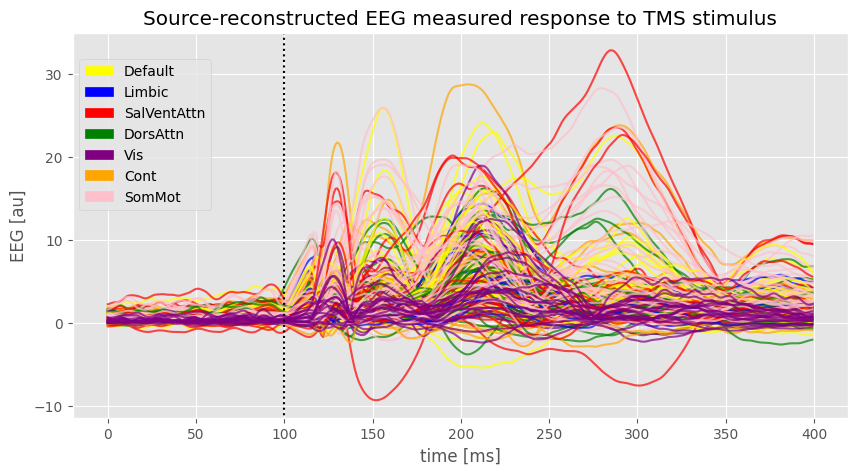

In [205]:
data_ts = data_pytepfit['ts']
plot_data(data_ts,colors=color_based_on_yeo7,stimulation_time=stimulation_time,title="Source-reconstructed EEG measured response to TMS stimulus")
plt.savefig(paths.path_figures(fig_dir+"data.pdf"),bbox_inches='tight',pad_inches=0)

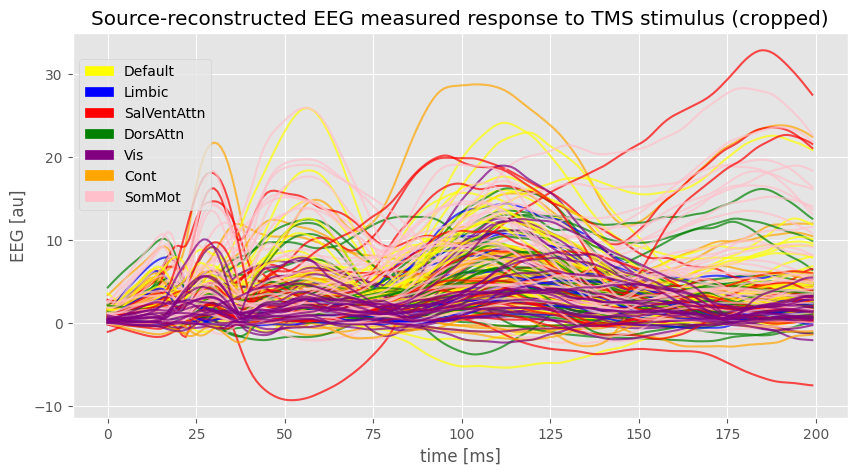

In [206]:
data_ts_croped = data_ts[stimulation_time:stimulation_time+RESPONSE_LENGTH,:]
plot_data(data_ts_croped,colors=color_based_on_yeo7,title="Source-reconstructed EEG measured response to TMS stimulus (cropped)")
plt.savefig(paths.path_figures(fig_dir+"cropped_data.pdf"),bbox_inches='tight',pad_inches=0)
plt.show()

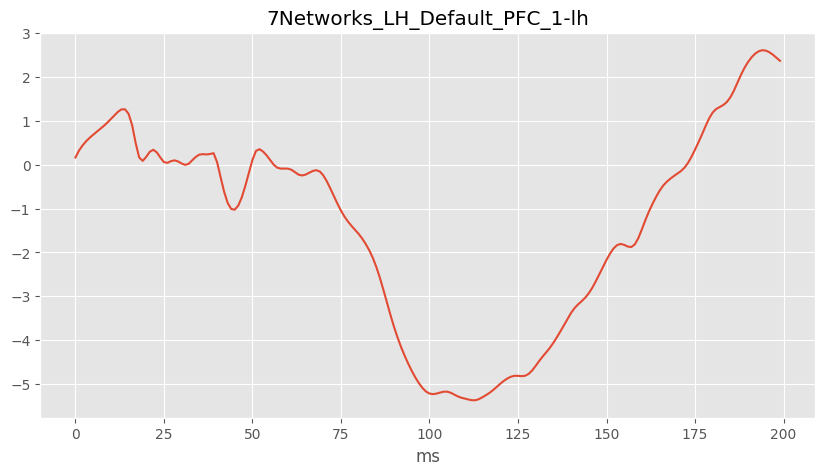

In [207]:
plot_one_roi(data_ts_croped,17,data_pytepfit['labels'])

In [208]:
def peak_analysis(sequence,threshold):
    peaks = signal.find_peaks(sequence,height=threshold)
    if len(peaks[0]) == 0:
        return np.nan, np.nan, np.nan, np.nan

    first_peak_time = peaks[0][0]
    first_peak_height = peaks[1]['peak_heights'][0]
    max_peak_time = peaks[0][np.argmax(peaks[1]['peak_heights'])]
    max_peak_height = np.max(peaks[1]['peak_heights'])

    return first_peak_time, first_peak_height, max_peak_time, max_peak_height

def estimate_auc(seqence, threshold):
    estimate = 0

    for v in seqence:
        if v > threshold:
            estimate += v

    if estimate > 0:
        return estimate

    return None
    

def get_threshold_range(data,stim_idx):
    maxima = np.max(data[stim_idx:,:],axis=0)
    print(maxima.shape)
    maxima.sort()

    upper = int(maxima[-30]) # for higest threshold there should be at least 30 responses above for statistics
    lower = int(np.max(data[:stim_idx,:]))
    step = int((upper - lower) / 7)

    if step <1:
        step = 1

    return range(lower, upper, step)

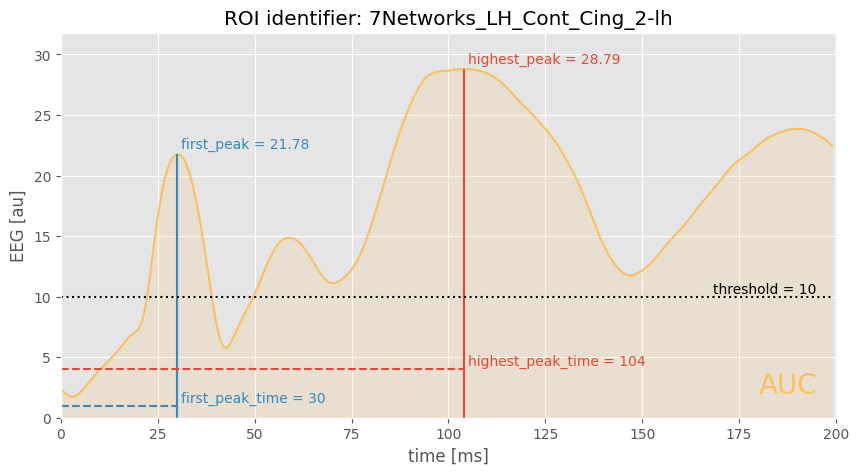

In [209]:
colors=['#E24A33', '#348ABD', '#8EBA42', '#777777','#FBC15E', '#FFB5B8', '#988ED5']

def plot_one_roi_response_definitions(data,roi_id,labels,thr):
    plt.rcParams['figure.figsize'] = [10, 5]
    selected_curve = data[:,roi_id]

    amp_id, amp, amp_h_id, amp_h = peak_analysis(selected_curve,threshold=thr)

    auc_color = colors[4]
    first_peak_color = colors[1]
    highest_peak_color = colors[0]

    plt.figure()

    plt.plot(data[:,roi_id],color=auc_color)
    plt.fill_between([i for i in range(len(selected_curve))],selected_curve,alpha=0.15,color=auc_color)
    plt.text(RESPONSE_LENGTH-20, 2, "AUC",color=auc_color,fontsize=20)

    plt.vlines(amp_id, 0, amp,color=first_peak_color)
    plt.text(amp_id+1, amp+0.5, f"first_peak = {amp:.2f}",color=first_peak_color)
    plt.plot([1]*(amp_id+1),color=first_peak_color,ls="--")
    plt.text(amp_id+1, 1+0.3, f"first_peak_time = {amp_id}",color=first_peak_color)

    plt.vlines(amp_h_id, 0, amp_h,color=highest_peak_color)
    plt.text(amp_h_id+1, amp_h+0.5, f"highest_peak = {amp_h:.2f}",color=highest_peak_color)
    plt.plot([4]*(amp_h_id+1),color=highest_peak_color,ls="--")
    plt.text(amp_h_id+1, 4+0.3, f"highest_peak_time = {amp_h_id}",color=highest_peak_color)

    ax = plt.gca()
    ax.set_ylim([0,amp_h+3])
    ax.set_xlim([0, len(selected_curve)])

    
    plt.title(f"ROI identifier: {labels[roi_id]}")
    plt.plot([thr]*len(selected_curve),color="k",ls=":")
    plt.text(len(selected_curve)-5, thr+0.3, f"threshold = {thr}",color='k',horizontalalignment='right')
    plt.xlabel("time [ms]")
    plt.ylabel("EEG [au]")
    
    path = paths.path_figures(fig_dir+labels[roi_id]+"_response_def.pdf")
    plt.savefig(path,bbox_inches='tight',pad_inches=0)
    plt.show()

if RESPONSE_LENGTH > 100:
    plot_one_roi_response_definitions(data_ts_croped,1,labels=data_pytepfit['labels'],thr=10)

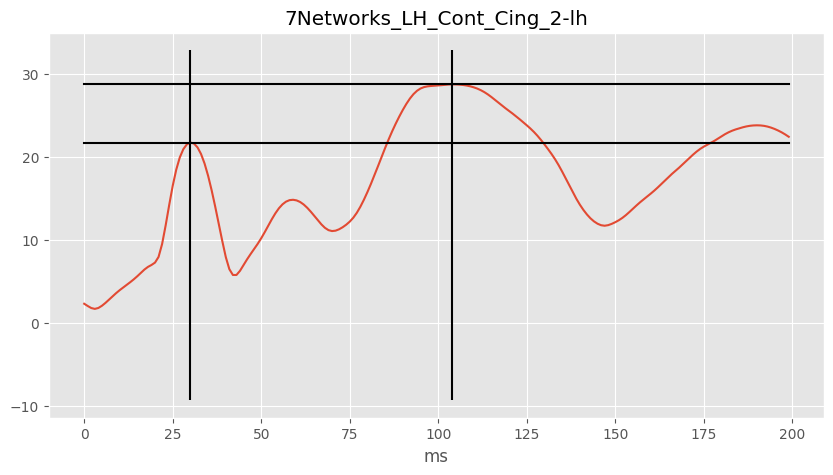

In [210]:
roi_idx = 1

amp_id, amp, amp_h_id, amp_h = peak_analysis(data_ts_croped[:,roi_idx],threshold=8)


plot_one_roi(data_ts_croped,roi_idx,labels=data_pytepfit['labels'],constants_h=[amp,amp_h],constants_v=[amp_id,amp_h_id])

In [211]:
responses = {} 
stim_time = 100

df_responses = pd.DataFrame()

thr_range = get_threshold_range(data_ts,stim_time)
list_of_thresholds = []

for threshold in thr_range:

    response_df = pd.DataFrame(index=range(200))

    response_df['01-response'] =  np.where(np.max(data_ts_croped,axis=0) > threshold,1,0)

    peak_analysis_results = np.zeros((200,4),dtype=float)
    for i in range(200):
        peak_analysis_results[i] = peak_analysis(data_ts_croped[:,i],threshold)

    response_df['first_peak_time'] = peak_analysis_results[:,0]
    response_df['first_peak'] = peak_analysis_results[:,1]
    response_df['highest_peak_time'] = peak_analysis_results[:,2]
    response_df['highest_peak'] = peak_analysis_results[:,3]

    response_df['variance'] = np.var(data_ts_croped,axis=0)
    response_df['diff'] = np.max(data_ts_croped,axis=0)-np.min(data_ts_croped,axis=0)

    response_df['AUC'] = np.array([sk_metrics.auc(list(range(len(data_ts_croped[:,i]))), data_ts_croped[:,i]) for i in range(200)],dtype=float)
    response_df['AUC_curve_above_thr'] = np.array([sk_metrics.auc(list(range(len(data_ts_croped[:,i]))), (data_ts_croped[:,i]-threshold).clip(min=0)) for i in range(200)],dtype=float)
    response_df['mean'] = np.array([np.mean(data_ts_croped[:,i]) for i in range(200)],dtype=float)
    response_df['power'] = np.array([np.sum(data_ts_croped[:,i]**2) for i in range(200)],dtype=float)

    for c in ['variance','diff','AUC','AUC_curve_above_thr','mean','power']:
        response_df[c] = np.where(response_df['01-response'],response_df[c],WHEN_NOT_OVER_THRESHOLD)

    responses[threshold] = response_df
    list_of_thresholds.append(threshold)

(200,)


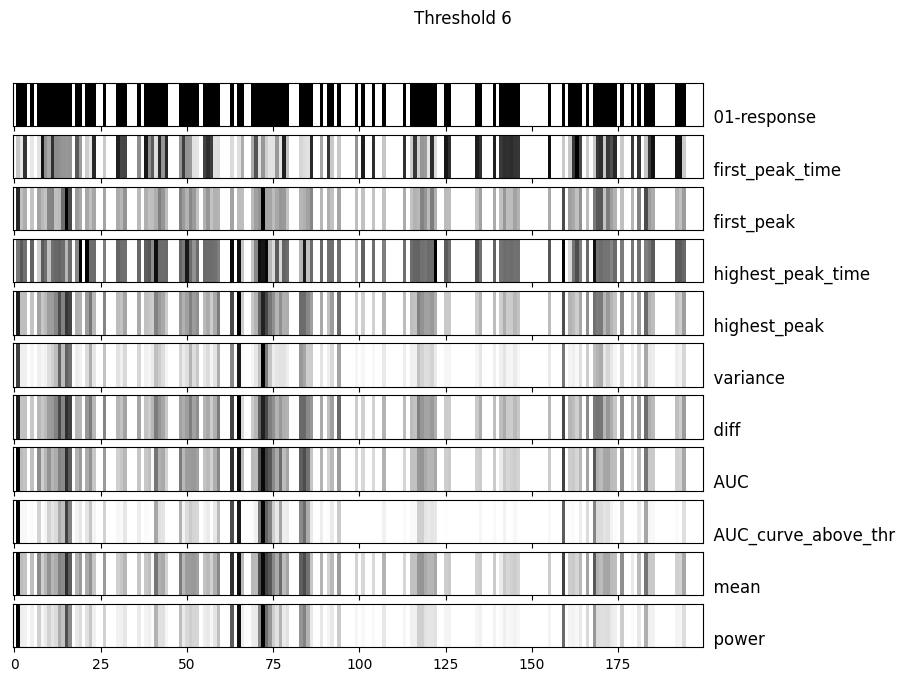

In [212]:
thr = list_of_thresholds[2]

fig, axs = plotting.prepare_barcode(len(responses[thr].columns),200,title=f"Threshold {thr}")


for i,c in enumerate(responses[thr].columns):
    plotting.plot_one_barcode(axs[i],responses[thr][c],title=c)

In [213]:
stim_locatin = 85 # we know this from previous notebooks

### Load structural connectivity data

In [214]:
centroids_file = paths.path('interim/schaefer_parcellation_mappings/ROI_MAPPING_pytepfit.csv')
centroids_mne = data.get_centroids_from_file(centroids_file,"geom_mne")

ED = data.roi_distances_from_centroids(centroids_mne)

In [215]:
SC_matrices = data.load_set_of_schaefer_matrices_for_pytepfit(ED=ED)

SC_matrices_filtered = []

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data
    pivot = matrix_filtering.find_pivot_to_keep_xpercent_edges(SC_W,GRAPH_DENSITY)
    SC_W = np.where(SC_W>=pivot,SC_W,0)
    if SC_L is not None:
        SC_L = np.where(SC_W>=pivot,SC_L,np.nan)
    SC_W_log = np.where(SC_W>=pivot,SC_W_log,np.nan)
    SC_matrices_filtered.append((name, SC_W, SC_L, SC_W_log))

SC_matrices = SC_matrices_filtered

/home/katterrina/fi_muni/0_diplomka/src/data.py:134: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append(("PyTepFit_simple",SC_W_pytep, SC_L_pytep,np.log(SC_W_pytep)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


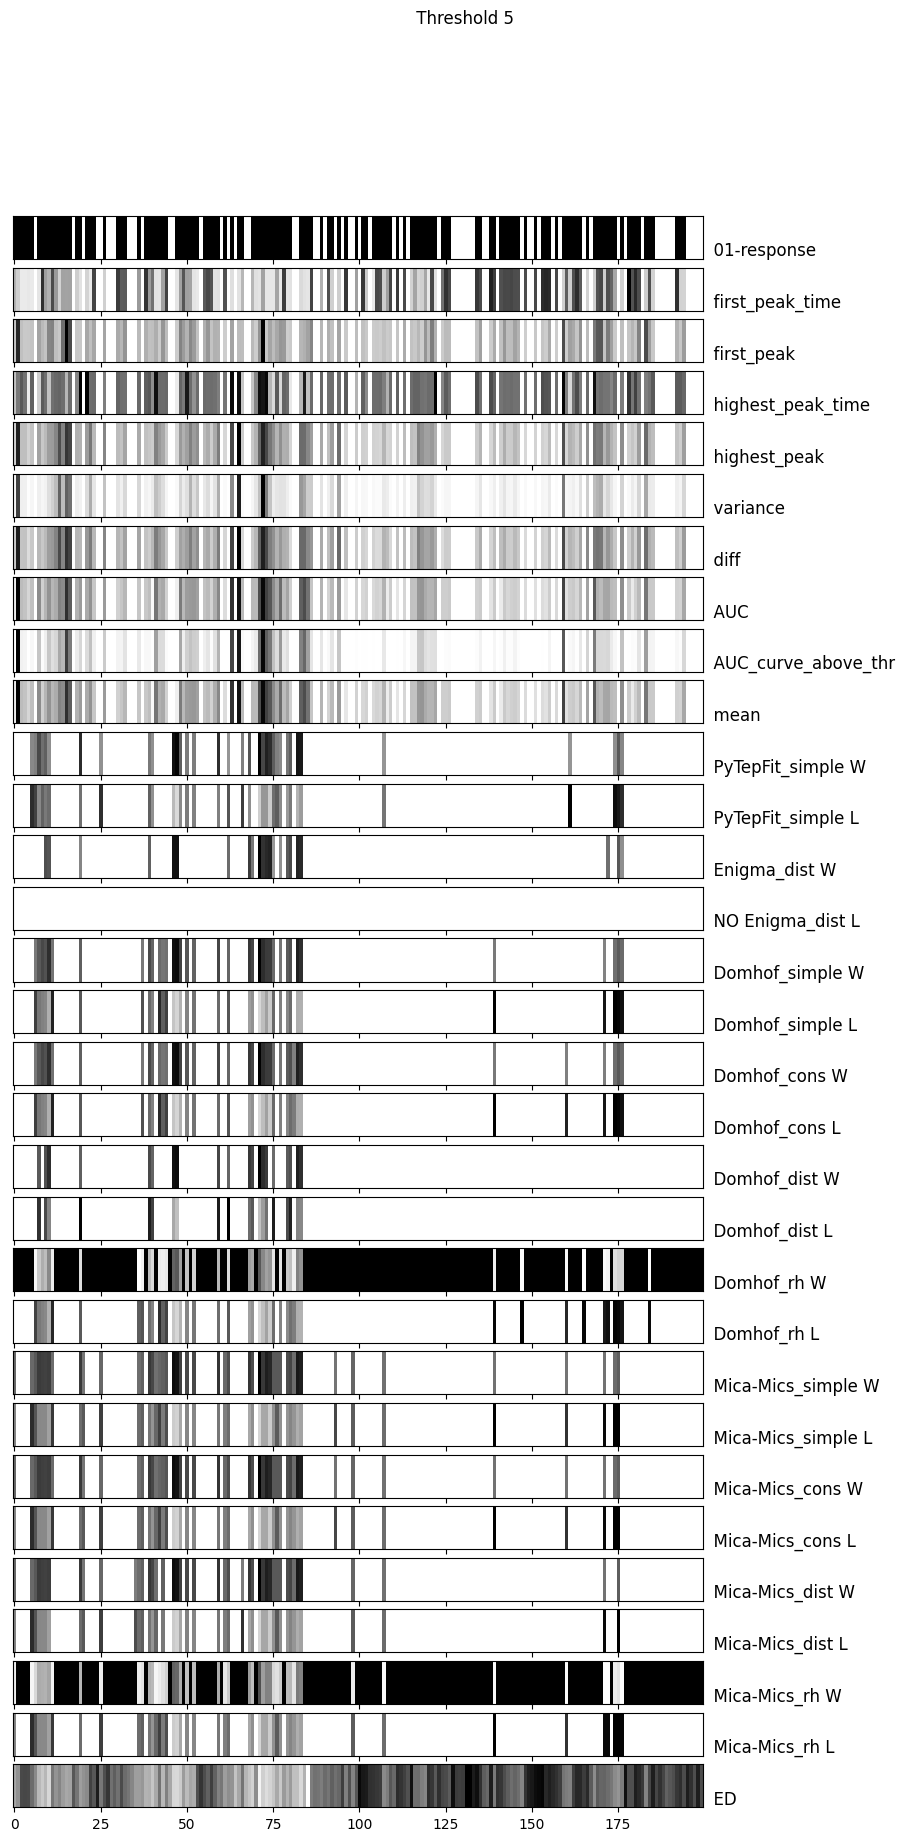

In [216]:
thr = list_of_thresholds[1]
n_of_response_def = len(responses[thr].columns)

fig, axs = plotting.prepare_barcode(n_of_response_def+2*len(SC_matrices),200, title = f" Threshold {thr}")

for i,c in enumerate(responses[thr].columns):
    plotting.plot_one_barcode(axs[i],responses[thr][c],title=c)

for j,d in enumerate(SC_matrices):
    name, SC_W,SC_L,SC_W_log = d
    plotting.plot_one_barcode(axs[i+2*j],SC_W_log[stim_locatin],title=f"{name} W")
    if SC_L is not None:
        plotting.plot_one_barcode(axs[i+2*j+1],SC_L[stim_locatin],title=f"{name} L")
    else:
        z = np.zeros(SC_W_log[stim_locatin].shape)
        plotting.plot_one_barcode(axs[i+2*j+1],z,title=f"NO {name} L")

plotting.plot_one_barcode(axs[-1],ED[stim_locatin],title=f"ED")
plt.savefig(paths.path_figures(fig_dir+"barcode.pdf"),bbox_inches='tight',pad_inches=0)

In [217]:
all_responses = pd.concat(responses)
all_responses

01-response  first_peak_time  first_peak  highest_peak_time  \
4  0              1             47.0    5.816432               47.0   
   1              1             30.0   21.778551              104.0   
   2              1             13.0    6.474365              128.0   
   3              1             13.0    5.517997              109.0   
   4              1             15.0    5.643366               15.0   
...             ...              ...         ...                ...   
13 195            0              NaN         NaN                NaN   
   196            0              NaN         NaN                NaN   
   197            0              NaN         NaN                NaN   
   198            0              NaN         NaN                NaN   
   199            0              NaN         NaN                NaN   

        highest_peak   variance       diff          AUC  AUC_curve_above_thr  \
4  0        5.816432   3.123393   6.224032   253.332072            18.783715   
   1       28.793386  55.774696  27.077971  3429.233902          2648.501212   
   2        8.258207   4.778983   7.251653   899.571678           241.025893   
   3        8.355309   4.468710   7.336567   795.702728           169.231327   
   4        5.643366   0.600524   4.283547   560.813191            10.066674   
...              ...        ...        ...          ...                  ...   
13 195           NaN        NaN        NaN          NaN                  NaN   
   196           NaN        NaN        NaN          NaN                  NaN   
   197           NaN        NaN        NaN          NaN                  NaN   
   198           NaN        NaN        NaN          NaN                  NaN   
   199           NaN        NaN        NaN          NaN                  NaN   

             mean         power  
4  0     1.280818    952.777344  
   1    17.208191  70379.312500  
   2     4.514212   5031.417969  
   3     3.990539   4078.622070  
   4     2.813737   1703.527832  
...           ...           ...  
13 195        NaN           NaN  
   196        NaN           NaN  
   197        NaN           NaN  
   198        NaN           NaN  
   199        NaN           NaN  

[2000 rows x 11 columns]

## One selected SC matrix

Select Mica-Mics structural with RH preprocessing, because we already know that it results into correlations for F-Tract.

In [218]:
for i, m in enumerate(SC_matrices):
    print(i, m[0])

0 PyTepFit_simple
1 Enigma_dist
2 Domhof_simple
3 Domhof_cons
4 Domhof_dist
5 Domhof_rh
6 Mica-Mics_simple
7 Mica-Mics_cons
8 Mica-Mics_dist
9 Mica-Mics_rh


In [219]:
for i, m in enumerate(SC_matrices):
    if SELECTED_SC_MATRIX == m[0]:
        name, SC_W, SC_L, SC_W_log = m
        print(name)


Mica-Mics_dist


## Correlations

In [220]:
def select_response_by_definition(definition,rdict):
    new_df = pd.DataFrame()
    for thr in rdict.keys():
        new_df[f"{thr:02d}"] = rdict[thr][definition]
    
    return new_df  

In [221]:
def plot_df_as_heatmap(df,x_axis,y_axis,value,x_label="threshold",y_label="",p=None,title=None,ax=None):
    plt.figure(figsize=(8,8))
    pivot = df.pivot_table(index=x_axis, columns=y_axis, values=value,sort=False)
    if p is not None:
        pivot_p = df.pivot_table(index=x_axis, columns=y_axis, values=p,sort=False)
        pivot = pivot.where(pivot_p < 0.05)

    cmap = LinearSegmentedColormap.from_list('', ['#FF2200', 'white', '#FF2200'])# 'seismic'

    if ax is not None:
        sns.heatmap(pivot, annot=True,center=0,cmap=cmap,vmin=-1, vmax=1,ax=ax,square=True,cbar=False)
    else:
        ax = sns.heatmap(pivot, annot=True,center=0,cmap=cmap,vmin=-1, vmax=1,ax=ax,square=True,cbar=False)
    ax.set_title(title)
    ax.set(xlabel=x_label)
    ax.set(ylabel=y_label)
    plt.yticks(rotation=0) 
    plt.savefig(paths.path_figures(fig_dir+title+".pdf"),bbox_inches='tight',pad_inches=0)
    plt.show()

def corr_columns_of_two_matrices(responses_by_threshold,metrics):

    col_names_thresholds = list(responses_by_threshold.keys())
    col_names_SC = list(metrics.keys())

    df = pd.concat([responses_by_threshold,metrics], axis=1, join="inner")

    stat_pg = pg.pairwise_corr(df,columns=[col_names_thresholds,col_names_SC],method="spearman").round(3)

    return stat_pg

In [222]:
com_metrics_matrices = communicatin_metrics.calculate_communicatin_metrics(ED,SC_L,SC_W)

dict_metrics = {}
for c in com_metrics_matrices:
    dict_metrics[c] = com_metrics_matrices[c][stim_locatin]

df_metrics = pd.DataFrame(dict_metrics)
df_metrics

/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:23: RuntimeWarning: divide by zero encountered in divide
  metrics_dict["SPE"] = np.divide(1,shortest_paths)
/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:26: RuntimeWarning: divide by zero encountered in divide
  shortest_paths,_ = metrics.distance_wei_floyd(1/SC_W)
/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:27: RuntimeWarning: divide by zero encountered in divide
  metrics_dict["SPE_W"] = np.divide(1,shortest_paths)


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:553: RuntimeWarning: divide by zero encountered in log2
  SI[i, j] = -np.log2(np.prod(pr_step_ff))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:554: RuntimeWarning: divide by zero encountered in log2
  SI[j, i] = -np.log2(np.prod(pr_step_bk))
/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:47: RuntimeWarning: divide by zero encountered in divide
  metrics_dict["NAV"] = np.divide(1,nav_paths)
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:781: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


,ED,SC_W,SC_L,SPE,SPE_W,COM,SI,SI_L,NAV,DIF
0,45.307805,431.193948,56.91748,0.017569,3171.461133,0.006233,8.40577,8.405770,0.017569,0.004508
1,56.289608,0.000000,inf,0.012035,2201.537812,0.001491,inf,13.893915,0.008399,0.003313
2,92.766248,0.000000,inf,0.008308,2214.649461,0.000319,inf,13.235508,0.006877,0.001788
3,94.172221,0.000000,inf,0.008227,2438.914265,0.001318,inf,16.011012,0.008135,0.004109
4,92.564602,0.000000,inf,0.008188,2253.693180,0.000852,inf,13.030661,0.008065,0.003664
...,...,...,...,...,...,...,...,...,...,...
195,115.547602,0.000000,inf,0.006106,1548.695058,0.000003,inf,23.485823,0.005798,0.003848
196,105.548873,0.000000,inf,0.006081,1631.045290,0.000003,inf,19.548383,0.000000,0.003585
197,90.633878,0.000000,inf,0.008401,1607.480024,0.000004,inf,17.240855,0.006925,0.001631
198,114.749213,0.000000,inf,0.006075,1613.067217,0.000002,inf,20.293128,0.000000,0.003441


0it [00:00, ?it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,200,-0.183,"[-0.31, -0.05]",0.009,0.741
1,04,SC_W,spearman,two-sided,200,0.095,"[-0.04, 0.23]",0.182,0.267
2,04,SC_L,spearman,two-sided,200,-0.105,"[-0.24, 0.03]",0.141,0.314
3,04,SPE,spearman,two-sided,200,0.164,"[0.03, 0.3]",0.020,0.643
4,04,SPE_W,spearman,two-sided,200,0.152,"[0.01, 0.28]",0.032,0.577
...,...,...,...,...,...,...,...,...,...
95,13,COM,spearman,two-sided,200,0.161,"[0.02, 0.29]",0.023,0.626
96,13,SI,spearman,two-sided,199,-0.088,"[-0.22, 0.05]",0.217,0.235
97,13,SI_L,spearman,two-sided,199,-0.186,"[-0.32, -0.05]",0.008,0.752
98,13,NAV,spearman,two-sided,200,0.260,"[0.13, 0.38]",0.000,0.962


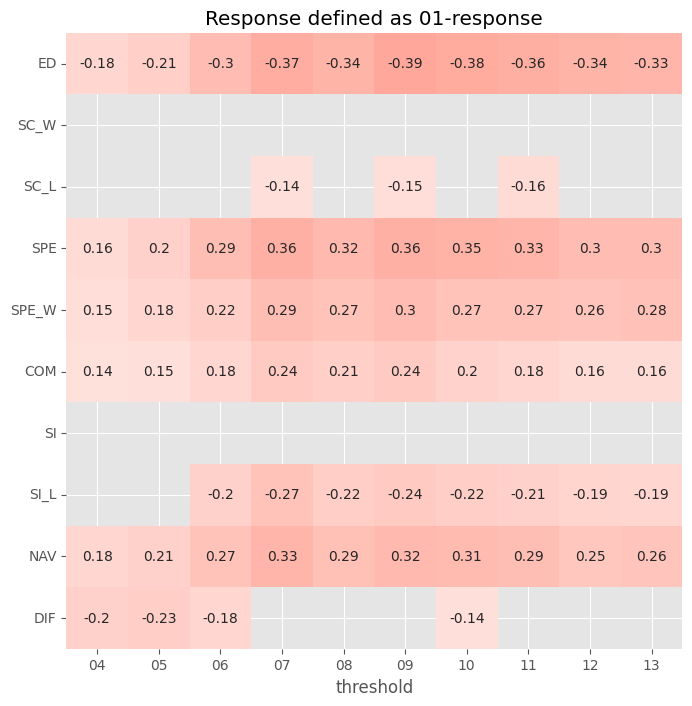

1it [00:01,  1.10s/it]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,-0.283,"[-0.42, -0.13]",0.000,0.952
1,04,SC_W,spearman,two-sided,157,0.120,"[-0.04, 0.27]",0.133,0.325
2,04,SC_L,spearman,two-sided,157,-0.143,"[-0.29, 0.01]",0.074,0.434
3,04,SPE,spearman,two-sided,157,0.287,"[0.14, 0.42]",0.000,0.957
4,04,SPE_W,spearman,two-sided,157,0.280,"[0.13, 0.42]",0.000,0.947
...,...,...,...,...,...,...,...,...,...
95,13,COM,spearman,two-sided,37,-0.004,"[-0.33, 0.32]",0.980,0.050
96,13,SI,spearman,two-sided,36,-0.085,"[-0.4, 0.25]",0.623,0.078
97,13,SI_L,spearman,two-sided,36,-0.101,"[-0.42, 0.24]",0.557,0.090
98,13,NAV,spearman,two-sided,37,0.070,"[-0.26, 0.39]",0.682,0.069


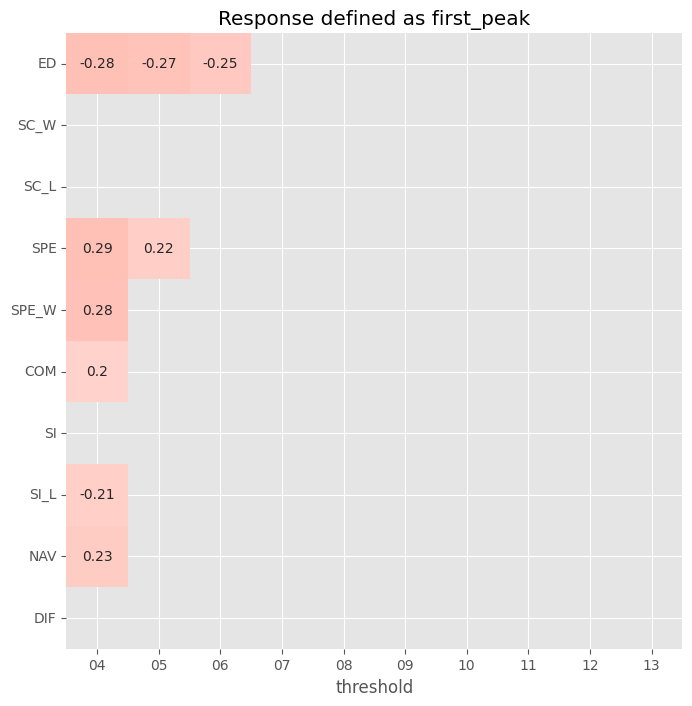

2it [00:01,  1.13it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,0.286,"[0.14, 0.42]",0.000,0.955
1,04,SC_W,spearman,two-sided,157,-0.230,"[-0.37, -0.08]",0.004,0.829
2,04,SC_L,spearman,two-sided,157,0.245,"[0.09, 0.39]",0.002,0.876
3,04,SPE,spearman,two-sided,157,-0.302,"[-0.44, -0.15]",0.000,0.973
4,04,SPE_W,spearman,two-sided,157,-0.338,"[-0.47, -0.19]",0.000,0.992
...,...,...,...,...,...,...,...,...,...
95,13,COM,spearman,two-sided,37,-0.385,"[-0.63, -0.07]",0.019,0.667
96,13,SI,spearman,two-sided,36,0.251,"[-0.08, 0.54]",0.140,0.320
97,13,SI_L,spearman,two-sided,36,0.321,"[-0.01, 0.59]",0.056,0.490
98,13,NAV,spearman,two-sided,37,-0.370,"[-0.62, -0.05]",0.024,0.630


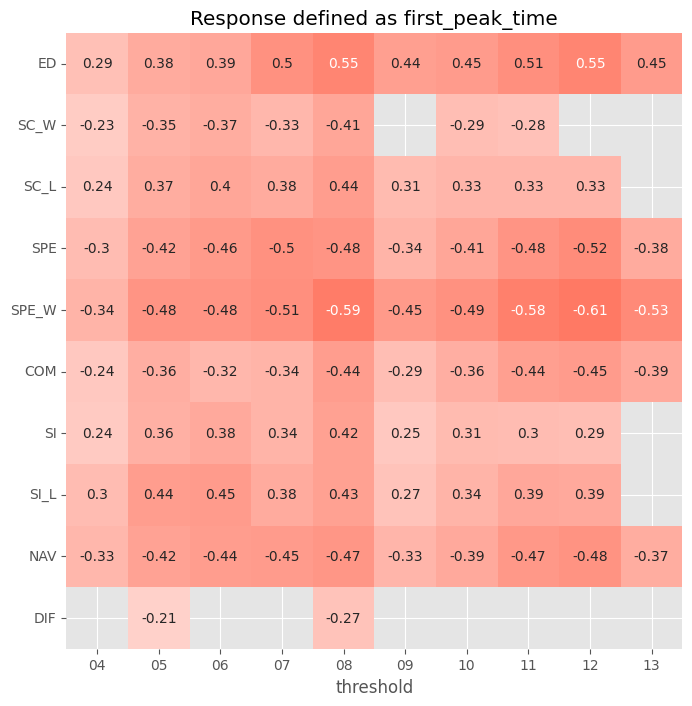

3it [00:02,  1.01it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,-0.403,"[-0.53, -0.26]",0.000,1.000
1,04,SC_W,spearman,two-sided,157,0.097,"[-0.06, 0.25]",0.227,0.228
2,04,SC_L,spearman,two-sided,157,-0.116,"[-0.27, 0.04]",0.147,0.306
3,04,SPE,spearman,two-sided,157,0.383,"[0.24, 0.51]",0.000,0.999
4,04,SPE_W,spearman,two-sided,157,0.308,"[0.16, 0.44]",0.000,0.977
...,...,...,...,...,...,...,...,...,...
95,13,COM,spearman,two-sided,37,0.224,"[-0.11, 0.51]",0.183,0.268
96,13,SI,spearman,two-sided,36,-0.055,"[-0.38, 0.28]",0.749,0.061
97,13,SI_L,spearman,two-sided,36,-0.196,"[-0.49, 0.14]",0.253,0.210
98,13,NAV,spearman,two-sided,37,0.138,"[-0.19, 0.44]",0.415,0.129


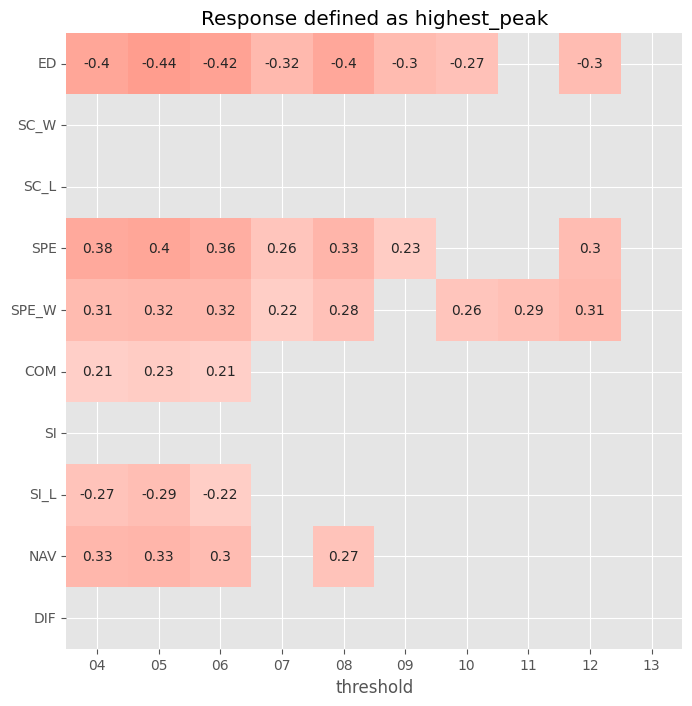

4it [00:03,  1.04it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,0.121,"[-0.04, 0.27]",0.131,0.329
1,04,SC_W,spearman,two-sided,157,-0.091,"[-0.24, 0.07]",0.256,0.206
2,04,SC_L,spearman,two-sided,157,0.142,"[-0.01, 0.29]",0.075,0.430
3,04,SPE,spearman,two-sided,157,-0.150,"[-0.3, 0.01]",0.060,0.471
4,04,SPE_W,spearman,two-sided,157,-0.155,"[-0.3, 0.0]",0.052,0.496
...,...,...,...,...,...,...,...,...,...
95,13,COM,spearman,two-sided,37,0.174,"[-0.16, 0.47]",0.304,0.178
96,13,SI,spearman,two-sided,36,0.053,"[-0.28, 0.38]",0.759,0.061
97,13,SI_L,spearman,two-sided,36,-0.068,"[-0.39, 0.27]",0.694,0.068
98,13,NAV,spearman,two-sided,37,-0.040,"[-0.36, 0.29]",0.816,0.056


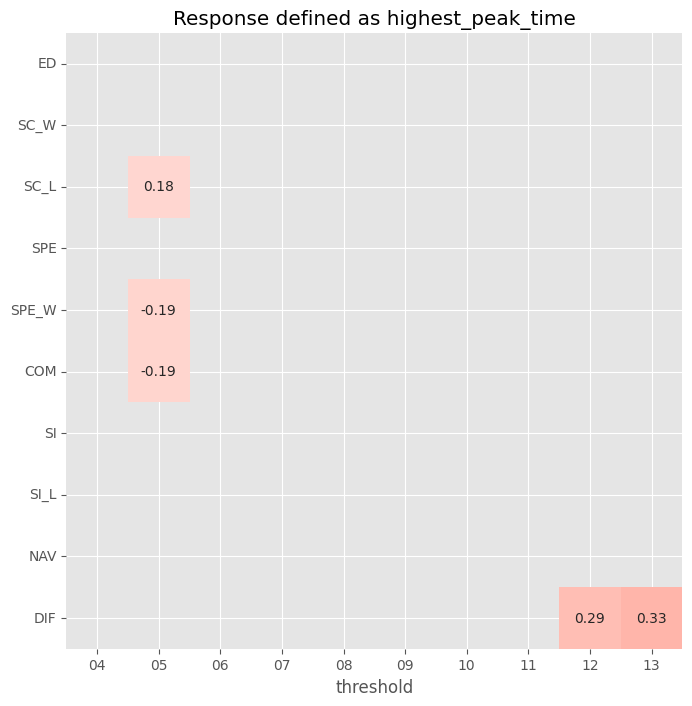

5it [00:04,  1.12it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,-0.456,"[-0.57, -0.32]",0.000,1.000
1,04,SC_W,spearman,two-sided,157,0.201,"[0.05, 0.35]",0.012,0.716
2,04,SC_L,spearman,two-sided,157,-0.215,"[-0.36, -0.06]",0.007,0.777
3,04,SPE,spearman,two-sided,157,0.431,"[0.29, 0.55]",0.000,1.000
4,04,SPE_W,spearman,two-sided,157,0.407,"[0.27, 0.53]",0.000,1.000
...,...,...,...,...,...,...,...,...,...
95,13,COM,spearman,two-sided,37,0.561,"[0.29, 0.75]",0.000,0.963
96,13,SI,spearman,two-sided,36,-0.369,"[-0.62, -0.05]",0.027,0.615
97,13,SI_L,spearman,two-sided,36,-0.525,"[-0.73, -0.24]",0.001,0.923
98,13,NAV,spearman,two-sided,37,0.568,"[0.3, 0.75]",0.000,0.967


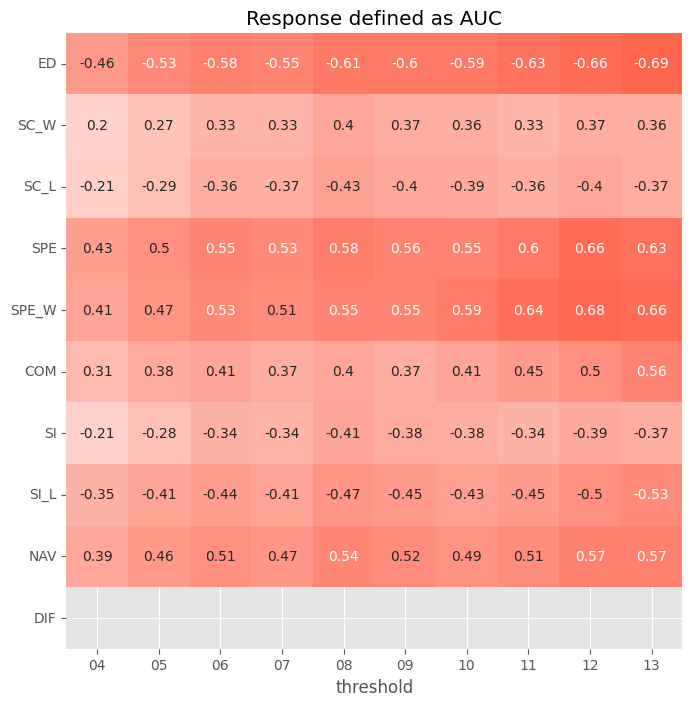

6it [00:05,  1.04it/s]


In [223]:
selected_response_definitions= ['01-response', 'first_peak', 'first_peak_time', 'highest_peak', 'highest_peak_time', 'AUC']
#pd.set_option('display.max_rows', None)

plt.style.use('ggplot')
for i,resp_definition in tqdm(enumerate(selected_response_definitions)):
    responses_df = select_response_by_definition(resp_definition,responses)  
    
    df = corr_columns_of_two_matrices(responses_df,df_metrics)
        
    display(df)
    
    plot_df_as_heatmap(df,"Y","X","r",p="p-unc",title=f"Response defined as {resp_definition}")


In [224]:
df_metrics['label'] = data_pytepfit['labels']

df_metrics_AUC = df_metrics.copy()
df_metrics_01 = df_metrics.copy()
df_metrics_FPT = df_metrics.copy()

for thr in list(responses.keys()):
    df_metrics_AUC["response"] = responses[thr]["AUC"]
    df_metrics_01["response"] = responses[thr]["01-response"]
    df_metrics_FPT["response"] = responses[thr]["first_peak_time"]

    df_metrics_AUC_id = df_metrics_AUC.set_index('label')
    df_metrics_01_id = df_metrics_01.set_index('label')
    df_metrics_FPT_id = df_metrics_FPT.set_index('label')

    df_metrics_AUC_id.to_csv(paths.path(f'{results_dir}response_AUC_and_communication_metrics_M1_pyTepFit_{RESPONSE_LENGTH}ms_thr{thr}.csv'))
    df_metrics_01_id.to_csv(paths.path(f'{results_dir}response_01_and_communication_metrics_M1_pyTepFit_{RESPONSE_LENGTH}ms_thr{thr}.csv'))
    df_metrics_FPT_id.to_csv(paths.path(f'{results_dir}response_FP_and_communication_metrics_M1_pyTepFit_{RESPONSE_LENGTH}ms_thr{thr}.csv'))